# Assignment I
*Digital Signal Processing, Innopolis University*

Author: **Artem Bakhanov** [a.bahanov@innopolis.university](mailto:a.bahanov@innopolis.university)

## Goals

In this assignment we are given a part of audio file that was recorded more than 100 years ago.

1) The problem is that sample rate and quantization levels (or quantization depth) of the file is not known and **need to be find**.

2) Another problem is a sine noise produced my a microphone (or recording device) that **should be removed**.

## Libraries and imports

**Important!**

Please run the cell below only if you work in my Docker Container

In [1]:
# run this only if you work in my docker container

import os
print("WD was: ", os.getcwd())
print("Now working in /content directory")
os.chdir("/content")

WD was:  /content/notebooks
Now working in /content directory


**Next cells can be run safely**

Install these libraries if you have not

In [2]:
!pip install numpy scipy matplotlib

In [2]:
from ADC_simulator import ADC
import numpy as np
from scipy.interpolate import interp1d
from numpy import fft
from matplotlib import pyplot as plt
from IPython.display import Audio

## Reading data and choosing sampling paramaters

In order to find fs I tried several parameters and have chosen the best.

Here I just selected 30k, it sounds OK

For quantization level I selected the smallest power of 2 to sound more or less good.

Also there is such a term in audio as audio bit depth, which stands for the number of bits for each sample (each channel individually). Usually it is from 16 to 24 bits.

In [20]:
v = 5 # student number from 1 to 14 (ask your TA to get it)
fs = 30000 # samples per second
samples = int(fs * 3.4) # number of samples to acquire

quant_levels = np.linspace(-1, 1, 2 ** 12)

# Sound recording
recorded_samples = ADC.rec(v, samples, quant_levels, fs)
t = np.arange(0, len(recorded_samples))

In [21]:
Audio(recorded_samples,rate=fs)

We can hear some strange and simple noise.

## Plotting the audio

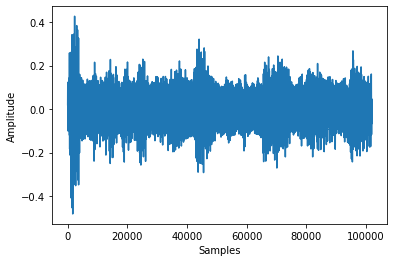

In [26]:
plt.plot(t, recorded_samples)
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.show()

## Finding the offset of the amplitude

In [27]:
mean = np.mean(recorded_samples)
mean

-1.2208099455093879e-17

Let us adjust the mean:

In [28]:
recorded_samples -= mean

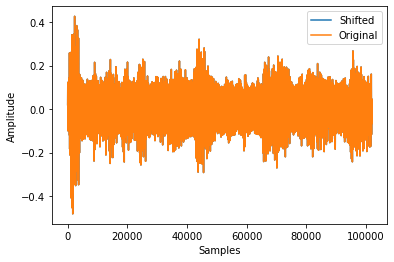

In [29]:
plt.plot(t, recorded_samples, label="Shifted")
plt.plot(t, recorded_samples + mean, label="Original")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.legend()
plt.show()

In [30]:
Audio(recorded_samples,rate=fs)

## FFT

Taking FFT of the samples will bring frequency spectra, which can be analyzed. 

In our case, we want to find some anomalies in the samples.

In [31]:
sp = fft.fft(recorded_samples)
freq = np.fft.fftfreq(len(sp)) * fs

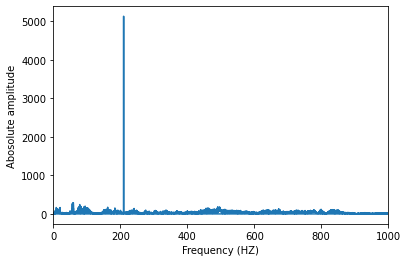

In [32]:
plt.plot(freq, np.abs(sp))
plt.xlabel("Frequency (HZ)")
plt.ylabel("Abosolute amplitude")
plt.xlim(0, 1000)
plt.show()

As we can see on the graph, there is one very high peak.

Since we are given an audio with sine noise, it means that this peak represents it with very high probability since the voice spectra consists of many different frequencies which in total give voice. The standart deviation of the amplitude is about 0.08 which is less than the given amplitude of the sine noise.

**Source:**
Mahdi, Jinan. (2019). Frequency analyses of human voice using fast Fourier transform. Iraqi Journal of Physics (IJP). 13. 174-181. 10.30723/ijp.v13i27.276. 

In [33]:
print(recorded_samples.std())

0.0839222756832999


In [34]:
peak = np.argmax(np.abs(sp))

# finding parameters of the wave 
noise_shift = np.angle(sp[peak])
noise_A = 2 * np.abs(sp[peak]) / len(sp)
noise_freq = freq[peak]

print(f"Noise shift: {noise_shift}")
print(f"Noise amplitude: {noise_A}")
print(f"Noise frequency (HZ): {noise_freq}")

Noise shift: -1.5494210131402464
Noise amplitude: 0.10069986509815629
Noise frequency (HZ): 210.0


As one can see, the noise shift (part of the phase) is very close to $\pi / 2$, which means that the signal is essentially a sine wave.

The amplitude is 0.1 as it was given in the task. We are going in a right direction.

In [35]:
noise_step = 2 * np.pi * noise_freq / fs
samples = np.arange(0, len(recorded_samples)) * noise_step
noise_sine = noise_A * np.cos(samples + noise_shift)

In [36]:
samples.shape

(102000,)

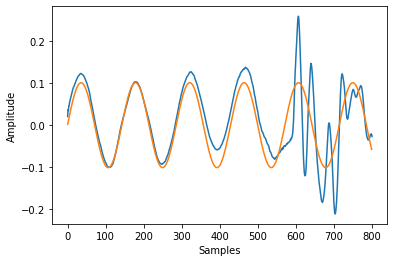

In [37]:
period_num = 5 * 160
plt.plot(np.linspace(0, period_num, period_num), recorded_samples[:period_num], noise_sine[:period_num])
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.show()

One can see here, that in period of silence there is a sine wave. 

If we take the sine wave with the parameters calculated above it will be almost the same!

Let us simply subtract our sine wave from the recorded samples and let see what we get.

In [38]:
Audio(recorded_samples - noise_sine, rate=fs)

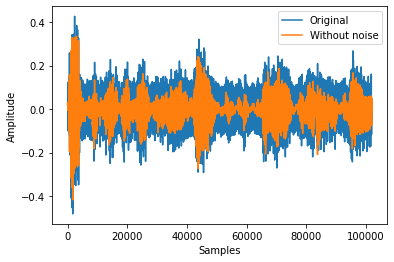

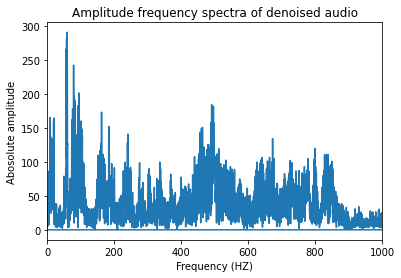

In [39]:
plt.plot(t, recorded_samples, label="Original")
plt.plot(t, recorded_samples - noise_sine, label="Without noise")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.legend()
plt.show()

sp = fft.fft(recorded_samples - noise_sine)
freq = np.fft.fftfreq(len(sp)) * fs
plt.plot(freq, np.abs(sp))
plt.xlabel("Frequency (HZ)")
plt.ylabel("Abosolute amplitude")
plt.title("Amplitude frequency spectra of denoised audio")
plt.xlim(0, 1000)
plt.show()

**There is no sine noise that was easily heard before!**

## Bonus task

I have found out that this method does not work in general so I decided to use fft to find approximate frequency and then explore neighbours of it.

Let us define L2 norm for audio as it is for vectors. We will try to minimize L2 norm of the signal, since sine wave added some additional amplitude to the signal.

The denoised audio with the smallest l2 norm will mean that it is the most dissimilar and will be the best.

In [40]:
def get_step(freq, fs):
    return 2 * np.pi * freq / fs

def remove_sine_noise(audio, fs):
    """
    Remove sine noise from a given audio.
    """
    
    # taking fft to find out the most notable sine wave
    sp = fft.fft(audio)
    freq = np.fft.fftfreq(len(sp)) * fs
    
    # the highest absolute amplitude
    peak = np.argmax(np.abs(sp))
    noise_A = 0.1 # given from the task
    noise_freq = np.abs(freq[peak])
    
    noise_freqs = np.linspace(noise_freq - 1.5, noise_freq + 1.5, 3000)
    noise_steps = 2 * np.pi * noise_freq / fs
    
    # getting random interval of ~500ms which will be used for comparing
    random_interval = np.random.randint(0, len(audio) - fs // 2)
    start, end = random_interval, random_interval + fs // 2
    check_interval = audio[start: end] # take 500ms
    samples = np.arange(start, end)
    
    # here L2 norm is mimimized with frequency step of 0.001
    min_dot = float("inf")
    best_freq = None
    
    # iterate over all possible freqs
    for freq in noise_freqs:
        noise_sine = 0.1 * np.sin(samples * get_step(freq, fs)) #noise_A * np.cos(samples + shift)
        dot_pr = np.linalg.norm(check_interval - noise_sine)
        
        if dot_pr < min_dot:
            min_dot = dot_pr
            best_freq = freq
            
        
    samples = np.arange(0, len(audio)) * get_step(best_freq, fs)
    
    return audio - 0.1 * np.sin(samples)
    return filtered

In [41]:
%%time
full_audio = np.array([])
fss = [0, 30000, 20000, 30000, 20000, 30000, 30000, 30000, 20000, 20000, 20000, 30000, 30000, 20000, 30000]

# I selected them by hands
lengths = [0, 160100, 53800, 112000, 77000, 112100, 144100, 176200, 82500, 78200, 91000, 141000, 115300, 110000, 224000]
main_fs = 32_000.0
size = 5

quant_levels = np.linspace(-1, 1, 512)

for i in range(1, 15):
    fs = fss[i]
    samples = lengths[i] #fs * size
    recorded_samples = ADC.rec(i, samples, quant_levels, fs)[:samples]
    
    # make it centered
    recorded_samples -= np.mean(recorded_samples)
    
    no_noise = remove_sine_noise(recorded_samples, fs)
    
    # we need to interpolate the parts to have the same pitch
    t = np.arange(0, len(recorded_samples)) / fs#np.linspace(0, , len(recorded_samples))
    main_t = np.arange(0, int(t[-1] * main_fs)) / main_fs #np.linspace(0, t[-1], t[-1] * main_fs)
    interpolated = interp1d(t, no_noise)(main_t)
    
    full_audio = np.concatenate((full_audio, interpolated))
    

CPU times: user 29.2 s, sys: 31.6 s, total: 1min
Wall time: 28.1 s


In [42]:
Audio(full_audio, rate=32000)

This is “Alone” written 
by Edgar Allan Poe.

https://www.poetryfoundation.org/poems/46477/alone-56d2265f2667d

## Conclusion
In this assigment, I have learned what sampling rate, quantization, FFT are and how to remove a simple noise wave from the audio signal.
I have used FFT to find parameters (amplitude, shift and frequency) of the noise. After that I tried to remove noise from the whole audio and FFT method did not work for all parts. Then I tried to use FFT results as approximate ones. I took frequency and tried to minimize L2 norm of the achieved signal within small neighbourhood. In simple words, it works because sine wave adds some additional amplitude to a very complex signal which includes silences, which has smaller amplitude. In the end, I have successfully removed noise from the whole audio and found out the original poem.

## Answers to the self-check questions

1. **What is the sampling rate?**

    It is actually a number of voltage (or any other) measurements per second. $T = \frac{1}{s_rate}$, where $T$ is period between measurements.
2. **How does one choose the sampling rate?**

    It depends on the quality they want to achieve. They need to take into account that sampling rate should be fast enough to be accurate and slow enough to be used in algorithms (save CPU and memory). Usually the sampling rate is given and no other additional thing needs to be done. In our case we looked at pitch knowing that it was a man so it should not be very high or low.
3. **What is quantization?**

    It is a method of converting analog signal to digital one. In simple words, each measurement is compared with quantization levels to find its "bucket", which is presented in a binary form understandable for a computer.
4. **How does one choose quantization levels?**

    It also depends on quality. For high quality results they need to select smaller quantization levels but they will consume more memory. In modern world usually 16 or 24 bits are used to represent the levels.
5. **Define a linear system. Describe the superposition principle.**

    A linear system is a system (deterministic) that uses linear operations (operators). It must follow homogenety and additivity properties: $H(ax) = aH(x)$ and $H(x) + H(y) = H(x + y)$. These two properties are called the superposition principle.

170773


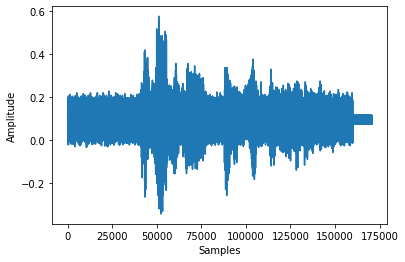

In [23]:
# just testing fs's
v = 1
fs = fss[v]
# fs = 12000 # samples per second
# samples = fs * 7 # number of samples to acquire
samples = lengths[v]# - 7000 #224000
quant_levels = np.linspace(-1, 1, 512)

# Sound recording
recorded_samples = ADC.rec(v, samples, quant_levels, fs)
print(len(recorded_samples))

plt.plot(np.arange(0, len(recorded_samples)), recorded_samples)
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.show()
Audio(recorded_samples, rate=fs)
# Audio(remove_sine_noise(recorded_samples, fs), rate=fs)